<a href="https://colab.research.google.com/github/boangri/neuraluniversity/blob/master/HW13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №13 "Генерация текстов" 18.10.2020

Борис Грибовский <xinu@yandex.ru>

## Подготовка данных

### Import библиотек

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

import tensorflow as tf
from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Flatten # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import Sequence, to_categorical, plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

from matplotlib import pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Мои функции и классы

In [ ]:
# Отделение знаков препинания пробелами
def replaceSigns(s):
    s = s.replace('.', ' . ')
    s = s.replace(',', ' , ')
    s = s.replace('!', ' ! ')
    s = s.replace('?', ' ? ')
    return s.lower()

# Исправленная версия
def strToTokens(sentence: str, maxlen=14): # функция принимает строку на вход (предложение с вопросом)
    words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
    tokensList = tokenizer.texts_to_sequences([words])
    return pad_sequences(tokensList, maxlen=maxlen , padding='post')

# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='Loss на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='Loss на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

# Делает батчи для обучения
class MySequence(Sequence):
    def __init__(self, x_set, y_set, voc_len, batch_size=50):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.voc_len = voc_len

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_z = np.zeros((self.batch_size, batch_y.shape[1], self.voc_len), dtype=np.int32)
        for n in range(self.batch_size):
            for j in range(batch_y.shape[1] - 1):
                batch_z[n, j, batch_y[n, j+1]] = 1
        return [batch_x, batch_y], batch_z

# Тестовые вопросы
myQuestions = [
               'А где возьмем-то?',
               'Где ты такому удару научился?', 
               'Ну, и как это было? ',
               'Сколько фрицев в котле?', 
               'Какой полк?',
               'А  с  тобой,  конечно, такого не случится?',
               'Привет! как дела?', 
               'Сколько времени?', 
               'Закурить не найдется?', 
               'Когда кончится война?', 
               'Куда ведет эта дорога?',
               'Где ближайший аэродром?',
               'Кто твой командир?',
               ]

# Тестирование inference-модели на вопросах
def testModel(encModel, decModel, questions, tokenizer, maxlen):
    for question in questions:
        question = replaceSigns(question)
        statesValues = encModel.predict(strToTokens(question))
        emptyTargetSeq = np.zeros((1, 1))    
        emptyTargetSeq[0, 0] = tokenizer.word_index['start']
        decodedTranslation = ''
        for i in range(maxlen): 
            decOutputs, h, c = decModel.predict([emptyTargetSeq] + statesValues)
            ind = np.argmax(decOutputs, axis=-1)[0, 0]
            if ind == 0:
                break
            sampledWord = tokenizer.index_word[ind]
            if sampledWord == 'end':
                break
            decodedTranslation += (' ' + sampledWord)
            emptyTargetSeq[0, 0] = ind 
            statesValues = [h, c] 
        
        print('Question: ' + question)
        print('Answer: ' + decodedTranslation)

# Для задания расписания для learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Парсинг данных

In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Базы/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[12]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Какими  судьбами  в  этих  краях?', 'Да... По случаю.']


In [ ]:
!head -30 '/content/drive/My Drive/Базы/Диалоги(рассказы).yml'

﻿разговоры:
- - Что,  Мансур,  не жарко теперь тебе? 
  - Спрашиваю, не жарко ему теперь?
- - Какой полк? 
  - Тысяча тридцать четвертый.
- - Тысяча тридцать шестая. 
  - Значит, наша! Принимай тяжелораненого!
- - Сколько фрицев в котле? 
  - Тысяч сорок.
- - У  меня  талоны. 
  - А ты?
- - А ты? 
  - У меня бутерброды с собой. И фанта.
- - Случилось что? 
  - Случилось.
- - А где возьмем-то? 
  - Да  тут  бабы  специальные  ездиют.
- - Не выношу таких!.. 
  - Где ты такому удару научился?
- - Где ты такому удару научился? 
  - Этому  всю  жизнь  учатся.
- - Как мама? 
  - Ничего.
- - Ничего. 
  - Как тетя Нина?
- - Какими  судьбами  в  этих  краях? 
  - Да... По случаю.
- - Да... По случаю. 
  - Какой заказ?
- - Что это ты притащила? 


In [ ]:
!tail -30 '/content/drive/My Drive/Базы/Диалоги(рассказы).yml'

- - Восемь тридцать пять. 
  - Но мне показалось...
- - Но мне показалось... 
  - ... Что ты спишь часа два. Знакомое чувство.
- - Это  по  твою  душу,  Олсон. 
  - Тебе-то  что?
- - Что с тобой? 
  - Теряю сознание.
- - Что? 
  - Хорошо, что мы живы.
- - Ну, и как это было? 
  - Тебе не понравится.
- - Прекрати. Ради Бога, прекрати. 
  - Ты хотел знать. Так ведь?
- - А ДЛИННЫЙ ПУТЬ - когда-нибудь останавливали? 
  - Не думаю. Что, материал для книги?
- - Гэррети. 
  - Что?
- - Я не помню всех, кому выписали пропуск. 
  - Я тоже.
- - Неудивительно. Странный он парень, правда? 
  - Правда.
- - Твой друг недоволен Майором? 
  - Я  думаю.
- - Олсон тоже бесится. Эй, Хэнк! 
  - Оставил бы ты его в покое.
- - Хэнк! Не желаешь пройтись? 
  - Иди к черту.
- - А  с  тобой,  конечно, такого не случится? 
  - Нет.

In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[2000]))
print('Ответ : {}'.format(answers[2000]))

Вопрос : Кто? - удивился Славик, - повариха что ли?
Ответ : <START> Ромашка. <END>


In [ ]:
# Это для PRO #1
# Отделяем знаки препинания от слов
for i, s in enumerate(questions):
    if isinstance(s, list):
        s = s[0]
    questions[i] = replaceSigns(s)

for i, s in enumerate(answers):
    if isinstance(s, list):
        s = s[0]
    answers[i] = replaceSigns(s)

In [ ]:
# Это для PRO #1
# Добавили oov_token, убрали знаки препинания из фильтра
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n', oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('.', 2), ('start', 3), ('end', 4), ('?', 5), (',', 6), ('что', 7), ('!', 8), ('не', 9), ('я', 10), ('а', 11), ('ты', 12), ('это', 13), ('да', 14), ('в', 15), ('нет', 16), ('как', 17), ('и', 18), ('вы', 19), ('ну', 20), ('с', 21), ('на', 22), ('же', 23), ('так', 24), ('он', 25), ('у', 26), ('кто', 27), ('где', 28), ('все', 29), ('мы', 30), ('то', 31), ('мне', 32), ('тебя', 33), ('меня', 34), ('здесь', 35), ('еще', 36), ('почему', 37), ('о', 38), ('там', 39), ('тебе', 40), ('есть', 41), ('его', 42), ('за', 43), ('куда', 44), ('вот', 45), ('ничего', 46), ('вас', 47), ('знаю', 48), ('чем', 49), ('но', 50)]
Размер словаря : 15108


### Подготовка выборки

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : какая же мораль  ?  
Пример кодированного вопроса на вход : [ 175   23 5714    5    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 19)
Установленная длина вопросов на вход : 19


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <start> никакой  .   так просто вспомнилось  .   <end>
Пример раскодированного ответа на вход : [    3   678     2    24    98 10562     2     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
Размеры раскодированного массива ответов на вход : (11900, 29)
Установленная длина ответов на вход : 29


### Разобьем все данные на тренировочные, валидационные и тестовые.

In [ ]:
# Перемешаем данные
inds = np.array([i for i in range(11900)])
np.random.shuffle(inds)

In [ ]:
x_train = paddedQuestions[inds[:10000]]
y_train = paddedAnswers[inds[:10000]]
x_val = paddedQuestions[inds[10000:10900]]
y_val = paddedAnswers[inds[10000:10900]]
x_test = paddedQuestions[inds[10900:11900]]
y_test = paddedAnswers[inds[10900:11900]]

In [ ]:
# сиквенсы для обучения - выдают батчи по 50
seq_train = MySequence(x_train, y_train, voc_len=vocabularySize, batch_size=50)
seq_val = MySequence(x_val, y_val, voc_len=vocabularySize, batch_size=50)
seq_test = MySequence(x_test, y_test, voc_len=vocabularySize, batch_size=50)

### Параметры нейросети и модель обучения

In [ ]:
DIM = 200
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, DIM,  mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(DIM, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, DIM, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(DIM, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    3021600     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    3021600     input_5[0][0]                    
_______________________________________________________________________________________

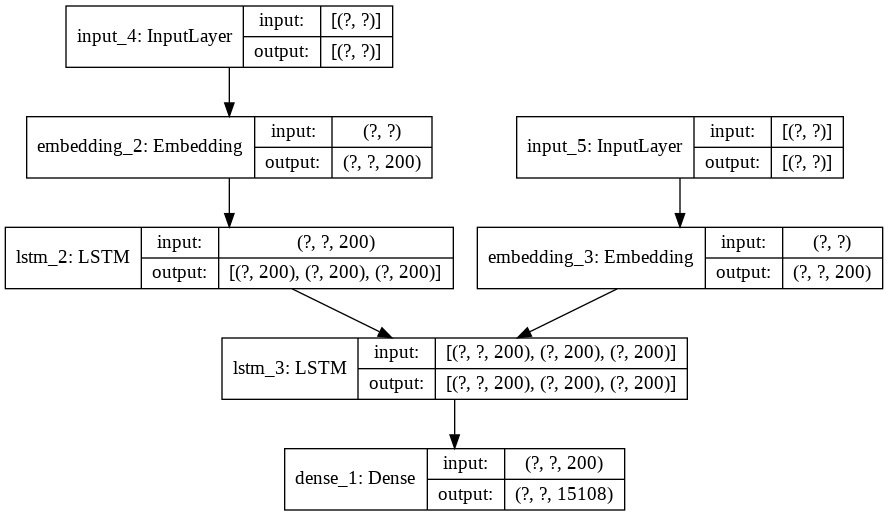

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
lh = LearnHistory()
print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png', show_shapes=True) # и построим график для визуализации слоев и связей между ними

### Подготовка и запуск рабочей нейросети с генерацией ответов

In [ ]:
# Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
encoderModel = Model(encoderInputs, encoderStates) 

decoderStateInput_h = Input(shape=(DIM,)) # обозначим размерность для входного слоя с состоянием state_h
decoderStateInput_c = Input(shape=(DIM,)) # обозначим размерность для входного слоя с состоянием state_c

decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

# Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою

decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)

decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

# Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
# на выходе предсказываемый ответ и новые состояния
decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

#Light задание 1

1) Используя три любых простых вопроса, сравните ответы сети на них на разной степени
натренированности:
+ 20 эпох – удается ли боту отвечать целыми словами?
+  +30 эпох на этой же сетке и с этими же вопросами – появился ли прогресс в качестве
ответа сети(ответ целыми предложениями разумной длины)?
+ Ещё + 50 эпох – удается ли сети выдавать ответы, “похожие на правду”?

In [ ]:
# Необученная модель:
testModel(encoderModel, decoderModel, myQuestions, tokenizer, maxLenAnswers)

Question: а где возьмем-то ? 
Answer:  гад указывай пера аста аста заложников наломали алексей подумал хранить подумал нелепый сердишься ложишься дрель дверцей танец ошибок чижика анак хотим барабанщики барабанщики заботилась писала напугалась печёнкин кивнул единой
Question: где ты такому удару научился ? 
Answer:  давит инъекцию пончо надумали корраль сестрой хороши медоуза продаю после правь скитер сейчас мелкие домового участия шмыгают пускай дойду дойду академия хххх налога раздался каникулы каникулы citoyens отменять светом
Question: ну ,  и как это было ?  
Answer:  безвыходно фонарь уши трубит водоеме магнитофон раздобыть квадрат мерзость побольше выскользнул подписывать раненый грис желаю умирай робить аппарату мелководье маленькое позвольте гипер маленькое создающие пруткову прюки соседний верный верный
Question: сколько фрицев в котле ? 
Answer:  умерли джоанна джоанна совершить принимать захотелось показывался купил недавно сожалеете айда негром моррис длинная денежки денеж

Необученная модель выводит бессвязный набор слов

Epoch 1/20
200/200 [==============================] - 27s 136ms/step - loss: 1.1598 - accuracy: 0.3092 - val_loss: 1.0163 - val_accuracy: 0.3975
Epoch 2/20
200/200 [==============================] - 25s 123ms/step - loss: 0.9793 - accuracy: 0.4083 - val_loss: 0.9831 - val_accuracy: 0.4100
Epoch 3/20
200/200 [==============================] - 25s 123ms/step - loss: 0.9410 - accuracy: 0.4278 - val_loss: 0.9656 - val_accuracy: 0.4344
Epoch 4/20
200/200 [==============================] - 25s 124ms/step - loss: 0.9136 - accuracy: 0.4452 - val_loss: 0.9581 - val_accuracy: 0.4447
Epoch 5/20
200/200 [==============================] - 25s 124ms/step - loss: 0.8930 - accuracy: 0.4517 - val_loss: 0.9566 - val_accuracy: 0.4499
Epoch 6/20
200/200 [==============================] - 25s 124ms/step - loss: 0.8751 - accuracy: 0.4571 - val_loss: 0.9557 - val_accuracy: 0.4515
Epoch 7/20
200/200 [==============================] - 25s 123ms/step - loss: 0.8579 - accuracy: 0.4639 - val_loss: 0.9585 - val_ac

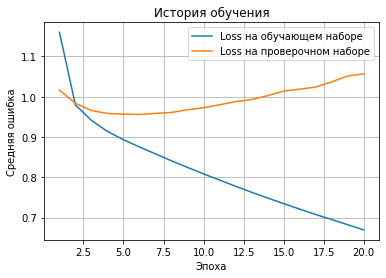

In [ ]:
# Запустим обучение 20 эпох
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(seq_train, validation_data=seq_val, epochs=20) 
lh.append(history)
lh.plot()

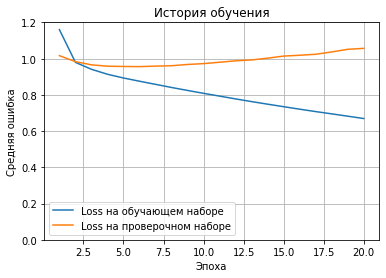

In [ ]:
lh.plot(ylim=1.2)

In [ ]:
# После 20 эпох:
testModel(encoderModel, decoderModel, myQuestions, tokenizer, maxLenAnswers)

Question: а где возьмем-то ? 
Answer:  в каком смысле ?
Question: где ты такому удару научился ? 
Answer:  я не знаю , что случилось .
Question: ну ,  и как это было ?  
Answer:  не знаю .
Question: сколько фрицев в котле ? 
Answer:  четыре года .
Question: какой полк ? 
Answer:  угу .
Question: а  с  тобой ,   конечно ,  такого не случится ? 
Answer:  нет .
Question: привет !  как дела ? 
Answer:  не знаю .
Question: сколько времени ? 
Answer:  в порядке .
Question: закурить не найдется ? 
Answer:  не знаю , сэр .
Question: когда кончится война ? 
Answer:  думаю , да .
Question: куда ведет эта дорога ? 
Answer:  как нибудь ?
Question: где ближайший аэродром ? 
Answer:  я здесь .
Question: кто твой командир ? 
Answer:  откройте !


Epoch 1/30
200/200 [==============================] - 31s 155ms/step - loss: 0.6611 - accuracy: 0.5621 - val_loss: 1.0695 - val_accuracy: 0.4029
Epoch 2/30
200/200 [==============================] - 29s 143ms/step - loss: 0.6187 - accuracy: 0.5692 - val_loss: 1.0785 - val_accuracy: 0.4059
Epoch 3/30
200/200 [==============================] - 28s 142ms/step - loss: 0.5631 - accuracy: 0.5844 - val_loss: 1.0982 - val_accuracy: 0.4020
Epoch 4/30
200/200 [==============================] - 28s 142ms/step - loss: 0.5032 - accuracy: 0.6077 - val_loss: 1.1288 - val_accuracy: 0.3933
Epoch 5/30
200/200 [==============================] - 29s 144ms/step - loss: 0.4465 - accuracy: 0.6444 - val_loss: 1.1591 - val_accuracy: 0.3872
Epoch 6/30
200/200 [==============================] - 29s 143ms/step - loss: 0.3945 - accuracy: 0.6882 - val_loss: 1.1812 - val_accuracy: 0.3922
Epoch 7/30
200/200 [==============================] - 29s 143ms/step - loss: 0.3458 - accuracy: 0.7264 - val_loss: 1.2078 - val_ac

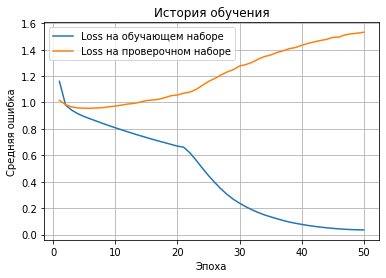

In [ ]:
# Запустим еще 30 эпох c Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(seq_train, validation_data=seq_val, epochs=30) 
lh.append(history)
lh.plot()

In [ ]:
# После 50 эпох:
testModel(encoderModel, decoderModel, myQuestions, tokenizer, maxLenAnswers)

Question: а где возьмем-то ? 
Answer:  на память , где с велосипедами .
Question: где ты такому удару научился ? 
Answer:  я даже в даже случае , кто будет будет .
Question: ну ,  и как это было ?  
Answer:  все .
Question: сколько фрицев в котле ? 
Answer:  тысяч сорок .
Question: какой полк ? 
Answer:  тысяча тридцать четвертый .
Question: а  с  тобой ,   конечно ,  такого не случится ? 
Answer:  нет .
Question: привет !  как дела ? 
Answer:  за дверью .
Question: сколько времени ? 
Answer:  около четырех .
Question: закурить не найдется ? 
Answer:  да нет , все чистая капитан .
Question: когда кончится война ? 
Answer:  в самый делать из себя .
Question: куда ведет эта дорога ? 
Answer:  у какого цветка ?
Question: где ближайший аэродром ? 
Answer:  а там сейчас уже .
Question: кто твой командир ? 
Answer:  гляди , что ты спросил .


После переключения на Адам обучение пошло быстрее, правда на валидационных данных видно явное переобучение. В результате после 50 эпох модель достаточно точно повторяет ответы из базы, а на произвольные вопросы (не из базы) выдает бессмысленные ответы.

Epoch 1/50
200/200 [==============================] - 31s 153ms/step - loss: 0.0174 - accuracy: 0.9810 - val_loss: 1.6035 - val_accuracy: 0.3651
Epoch 2/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0169 - accuracy: 0.9811 - val_loss: 1.6041 - val_accuracy: 0.3645
Epoch 3/50
200/200 [==============================] - 28s 141ms/step - loss: 0.0167 - accuracy: 0.9812 - val_loss: 1.6086 - val_accuracy: 0.3648
Epoch 4/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0165 - accuracy: 0.9813 - val_loss: 1.6095 - val_accuracy: 0.3646
Epoch 5/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0163 - accuracy: 0.9813 - val_loss: 1.6141 - val_accuracy: 0.3619
Epoch 6/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0161 - accuracy: 0.9810 - val_loss: 1.6182 - val_accuracy: 0.3645
Epoch 7/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0159 - accuracy: 0.9811 - val_loss: 1.6204 - val_ac

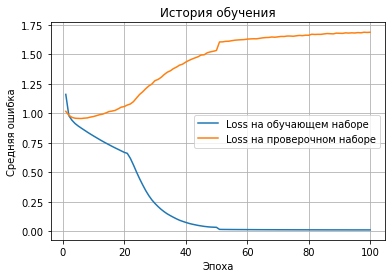

In [ ]:
# Добавим еще 50 эпох
model.compile(optimizer=Adam(lr=0.0002), loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(seq_train, validation_data=seq_val, epochs=50) 
lh.append(history)
lh.plot()

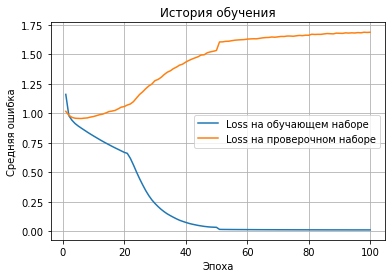

Question: а где возьмем-то ? 
Answer:  на войне , под ленинградом .
Question: где ты такому удару научился ? 
Answer:  я не знаю , когда я вас выйти .
Question: ну ,  и как это было ?  
Answer:  тебе не понравится .
Question: сколько фрицев в котле ? 
Answer:  тысяч сорок .
Question: какой полк ? 
Answer:  тысяча тридцать четвертый .
Question: а  с  тобой ,   конечно ,  такого не случится ? 
Answer:  нет .
Question: привет !  как дела ? 
Answer:  за вами . зачем ты хотела сказать ?
Question: сколько времени ? 
Answer:  около четырех .
Question: закурить не найдется ? 
Answer:  да нет , ничего не капитан .
Question: когда кончится война ? 
Answer:  в самый всегда место не смогу .
Question: куда ведет эта дорога ? 
Answer:  куда вызвали ? на землю !
Question: где ближайший аэродром ? 
Answer:  я здесь , сир .
Question: кто твой командир ? 
Answer:  ж . . . это твой отец .


In [ ]:
# После 100 эпох:
lh.plot()
testModel(encoderModel, decoderModel, myQuestions, tokenizer, maxLenAnswers)

После 100 эпох обучения модель хорошо запомнила ответы на вопросы из базы, но при этом произошло переобучение и ответы на произвольные вопросы в основном неудачные.

#PRO задание #1


##1) Попробуйте улучшить текущий скрипт чат-бота, 

внедрив блок кода для присвоения
словам вне словаря(out-of-vocabulary) метки “unknown” так, чтобы встретив в запросе
незнакомое слово, исполнение кода не останавливалось, а продолжалось, игнорируя
“unknown” слова.

Все необходимые изменения сделаны выше в разделе "Подготовка данных" и задании Light:
- добавлен oov_token; 
- знаки препинаний убраны из числа фильтруемых символов токнизатора; 
- в вопросах и ответах знаки препинаний отделены пробелами от слов;
- исправлена (2-мя способами) функция strToTokens()

In [ ]:
# Первый вариант - обрабатывать исключение - испозовать try - except
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    try:
        tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список
    except KeyError:
        pass
    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
# Второй вариант:
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = tokenizer.texts_to_sequences([words])
  return pad_sequences(tokensList, maxlen=maxLenQuestions , padding='post')

##2) Текущая модель не учитывает 
знаки препинания в диалоге. Скорректируйте некоторые
блоки кода так, чтобы они учитывались. Проведите наблюдения, как добавление знаков
скажется на работе и результатах сетки.

Выше (list "myQuestions") были протестированы вопросы со знаками препинаний. Они обрабатываются корректно, ошибок при выполнении не возникает. Модель активно использует точку, знак вопроса, восклицания в конце своих фраз. Раньше этого не было.

#PRO задание #2 
(альтернативное на выбор)
Добейтесь максимально низкого Loss’а в обучении модели, экспериментируя с
архитектурой и параметрами сети(размеры пространства эмбеддинга, слоев сетки,
разные оптимайзеры и т.п)

**Замечание** В задании не указано, на какой выборке требуется добиться минимальных потерь. На тренировочной выборке это сделать несложно, и уже было сделано выше. Сеть "вызубрила" ответы на известные вопросы, но при этом переобучилась и стала хуже отвечать на произвольные вопросы. 

Наверное наибольшую ценность имеет обучение сети отвечать на произвольные вопросы, для этого надо уменьшать потери на контрольной выборке.

Разобьем все данные, как положено по феншую, на тренировочные, валидационные и тестовые.

In [ ]:
# Перемешаем данные
inds = np.array([i for i in range(11900)])
np.random.shuffle(inds)

In [ ]:
# Пересоздадим выборки
x_train = paddedQuestions[inds[:10000]]
y_train = paddedAnswers[inds[:10000]]
x_val = paddedQuestions[inds[10000:10900]]
y_val = paddedAnswers[inds[10000:10900]]
x_test = paddedQuestions[inds[10900:11900]]
y_test = paddedAnswers[inds[10900:11900]]

In [ ]:
vocabularySize

15108

In [ ]:
# Увеличим размерность векторного (embedding) пространства. Добавим дропауты в LSTM для борьбы с переобучением.
# Перейдем на оптимизатор Adam
DIM = 256

encoderInputs = Input(shape=(None, ))
encoderEmbedding = Embedding(vocabularySize, DIM,  mask_zero=True) (encoderInputs)
encoderOutputs, state_h , state_c = LSTM(DIM, dropout=0.2, recurrent_dropout=0.2, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

decoderInputs = Input(shape=(None, ))
decoderEmbedding = Embedding(vocabularySize, DIM, mask_zero=True) (decoderInputs) 
decoderLSTM = LSTM(DIM, dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

model = Model([encoderInputs, decoderInputs], output)
lh = LearnHistory() 
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 256)    3867648     input_10[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 256)    3867648     input_11[0][0]                   
______________________________________________________________________________________

Нам нужны 3 сиквенса на каждый тип данных.

In [ ]:
seq_train = MySequence(x_train, y_train, voc_len=vocabularySize, batch_size=100)
seq_val = MySequence(x_val, y_val, voc_len=vocabularySize, batch_size=100)
seq_test = MySequence(x_test, y_test, voc_len=vocabularySize, batch_size=100)

In [ ]:
# Пробовал менять lr по расписанию.
# learning_rate = CustomSchedule(model)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
# temp_learning_rate_schedule = CustomSchedule(model)

# plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")

Epoch 1/20
100/100 [==============================] - 30s 302ms/step - loss: 1.4138 - accuracy: 0.1773 - val_loss: 1.1880 - val_accuracy: 0.2018
Epoch 2/20
100/100 [==============================] - 30s 298ms/step - loss: 1.0686 - accuracy: 0.3472 - val_loss: 1.0465 - val_accuracy: 0.4020
Epoch 3/20
100/100 [==============================] - 30s 296ms/step - loss: 0.9750 - accuracy: 0.4017 - val_loss: 1.0362 - val_accuracy: 0.4150
Epoch 4/20
100/100 [==============================] - 30s 296ms/step - loss: 0.9382 - accuracy: 0.4108 - val_loss: 1.0384 - val_accuracy: 0.4177
Epoch 5/20
100/100 [==============================] - 29s 294ms/step - loss: 0.9097 - accuracy: 0.4189 - val_loss: 1.0390 - val_accuracy: 0.4225
Epoch 6/20
100/100 [==============================] - 29s 292ms/step - loss: 0.8793 - accuracy: 0.4422 - val_loss: 1.0397 - val_accuracy: 0.4454
Epoch 7/20
100/100 [==============================] - 29s 289ms/step - loss: 0.8480 - accuracy: 0.4558 - val_loss: 1.0418 - val_ac

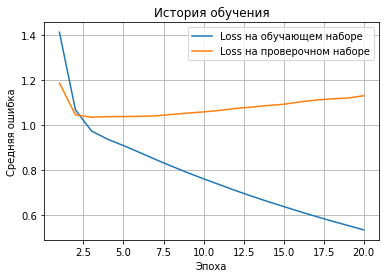

10/10 [==============================] - 1s 78ms/step - loss: 1.1634 - accuracy: 0.4091
Loss on test: 1.1634


In [ ]:
# Запустим обучение.
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(seq_train, validation_data=(seq_val), epochs=20) 
lh.append(history)
lh.plot()
score = model.evaluate(seq_test)
print("Loss on test: %.4f" % score[0])

##ВЫВОДЫ

Нейронная сеть является универсальным аппроксиматором, и есть теорема, утверждающая, что сеть способна обеспечить любую наперед заданную точность. Но это касается лишь обучаемых данных.
Поэтому задача снижения потерь на тренировочных данных не слишком трудна, нужно лишь взять досточно сложную сеть и нужное число эпох. Ценность такого обучения весьма ограничена - сеть лишь запомнит конкретные ответы на конкретные вопросы, но не сможет хорошо отвечать на произвольные вопросы.

Более ценным результатом было бы обучение, дающее малую потерю на _тестовом_ наборе. Однако в нашем случае добиться хорошего результата на тестовом наборе не получилось - несмотря на все предпринятые меры, очень быстро наступало переобучение, а потери оставались на высоком уровне. Я объясняю такой результат тем, что данные в ответах не вытекают логически из вопросов, и довольно произвольны. 

При обучении модели возникли серьезные проблемы с нехваткой памяти, так как OHE кодировка давала огромные массивы размера (11900, 16, 15107), приводившие к краху сессии. Поэтому мне пришлось создать свой сиквенс, выдающий данные в OHE формате батчами лишь по 50 штук. Это решило проблему.

К сожалению невозможно было полноценно протестировать предобученную модель, поскольку она обучалась, очевидно, на всех данных, и невозможно сказать какой бы у нее был результат на контрольной выборке. Кроме того, словарь у нее другой (без знаков препинаний) и запустить ее на моих данных ее нельзя.



#Ultra PRO задание #1
Скачайте свои переписки/диалоги из соц.сетей/мессенджеров и сформируйте свою
диалоговую базу. На основе этой базы обучите модель, построив тем самым чат бота,
генерирующего текст ответов в вашем стиле.

## Трансформер
Я мало общаюсь в соц сетях и к тому же не умею парсить их данные. Так что построить диалоговую базу, как предлагается в условии, не получится (или она будет неприемлемо маленькой)

В качестве альтернативной задачи я попытался поэкспериментировать с трансформером - архитектурой, которая стала общепризнанным лидером для задач NLP. 

Готового примера кода трансформера я не нашел. Пример трансформера из [документации Keras](https://keras.io/examples/nlp/text_classification_with_transformer/) содержит лишь блок энкодера. Я попытался написать свою реализацию блока декодера трансформера.

При написании я руководствовался статьями [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/), [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer) и оригинальной статьей [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

![image](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Модифицировал класс из примера для 2х входового слоя (понадобится в декодере)

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs[0])[0]
        query = self.query_dense(inputs[0])  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs[1])  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs[1])  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


Расширил класс MultiHeadSelfAttention для реализации маскирования.

In [ ]:
class MaskedMultiHeadSelfAttention(MultiHeadSelfAttention):
    def __init__(self, embed_dim, num_heads=8):
        super(MaskedMultiHeadSelfAttention, self).__init__(embed_dim)

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs[0])[0]
        query = self.query_dense(inputs[0])  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs[1])  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs[1])  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [ ]:
# Переименовал класс из примера и адаптировал к новому классу MultiHeadSelfAttention
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, input, training):
        attn_output = self.att([input, input])
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(input + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Добавил блок декодера.

In [ ]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerDecoderBlock, self).__init__()
        self.matt = MaskedMultiHeadSelfAttention(embed_dim, num_heads)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm0 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout0 = layers.Dropout(rate)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.matt([inputs[0], inputs[0]])
        attn_output = self.dropout0(attn_output, training=training)
        out0 = self.layernorm0(inputs[0] + attn_output)
        attn_output = self.att([out0, inputs[1]])
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(out0 + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
voc_size = 15107
embed_dim = 200  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer
enc_maxlen = 14
dec_maxlen = 16

enc_input = layers.Input(shape=(enc_maxlen,))
dec_input = layers.Input(shape=(dec_maxlen,))

enc_emb = TokenAndPositionEmbedding(enc_maxlen, voc_size, embed_dim)(enc_input)
dec_emb = TokenAndPositionEmbedding(dec_maxlen, voc_size, embed_dim)(dec_input)

# Для примера трансформер будет иметь 3 блока энкодеров и 3 блока декодеров
x = TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(enc_emb)
x = TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(x)
enc_out = TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(x)

x = TransformerDecoderBlock(embed_dim, num_heads, ff_dim)([dec_emb, enc_out])
x = TransformerDecoderBlock(embed_dim, num_heads, ff_dim)([x, enc_out])
dec_out = TransformerDecoderBlock(embed_dim, num_heads, ff_dim)([x, enc_out])
output = layers.Dense(voc_size, activation='softmax')(dec_out) 

# выделил в отдельные модели, хотя по-отдельности они не нужны.
Encoder = keras.Model(enc_input, enc_out, name="Encoder")
Decoder = keras.Model([dec_input, enc_input], output, name="Decoder")

model = keras.Model([enc_input, dec_input], output, name="Transformer")

# Параметры оптимайзера взяты из оригинальной статьи.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-09), loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding_6  (None, 14, 200)      3024200     input_8[0][0]                    
__________________________________________________________________________________________________
transformer_encoder_block_7 (Tr (None, 14, 200)      264456      token_and_position_embedding_6[0]
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 16)]         0                                            
________________________________________________________________________________________

Epoch 1/10
200/200 [==============================] - 18s 88ms/step - loss: 2.5853 - val_loss: 1.1395
Epoch 2/10
200/200 [==============================] - 16s 81ms/step - loss: 0.7958 - val_loss: 0.6825
Epoch 3/10
200/200 [==============================] - 16s 80ms/step - loss: 0.4531 - val_loss: 0.5803
Epoch 4/10
200/200 [==============================] - 16s 80ms/step - loss: 0.2643 - val_loss: 0.5373
Epoch 5/10
200/200 [==============================] - 16s 79ms/step - loss: 0.1311 - val_loss: 0.5053
Epoch 6/10
200/200 [==============================] - 16s 79ms/step - loss: 0.0375 - val_loss: 0.5225
Epoch 7/10
200/200 [==============================] - 16s 79ms/step - loss: 0.0035 - val_loss: 0.5600
Epoch 8/10
200/200 [==============================] - 16s 79ms/step - loss: 3.7068e-04 - val_loss: 0.5524
Epoch 9/10
200/200 [==============================] - 16s 78ms/step - loss: 6.6628e-05 - val_loss: 0.5688
Epoch 10/10
200/200 [==============================] - 16s 79ms/step - los

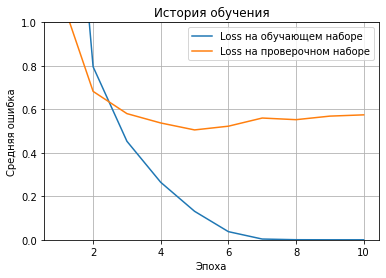

20/20 [==============================] - 1s 30ms/step - loss: 0.5613
Loss on test: 0.5613


In [ ]:
lh = LearnHistory()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-09), 
              loss='categorical_crossentropy')
            #   metrics=['accuracy'])
# Запустим обучение 
history = model.fit(sec_train, validation_data=(sec_val), epochs=10) 
lh.append(history)
lh.plot(ylim=1)
score = model.evaluate(sec_test)
print("Loss on test: %.4f" % score)

Трансформер обучается на удивление быстро (уже с 5-й эпохи начинается переобучение), но не менее качественно.

### Тестирование

я сделал тестирование на примере "игрушечного" переводчика с русского на английский. (См. ниже)

## Chat bot

Делаем чат-бот на базе трансформера (точнее его одного блока) 

In [ ]:
!wget https://xland.ru/uai/hw13/answer_database.txt

--2020-10-22 12:58:00--  https://xland.ru/uai/hw13/answer_database.txt
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52972439 (51M) [text/plain]
Saving to: ‘answer_database.txt’

answer_database.txt 100%[===================>]  50.52M  60.2MB/s    in 0.8s    

2020-10-22 12:58:01 (60.2 MB/s) - ‘answer_database.txt’ saved [52972439/52972439]



In [ ]:
# Словарь "Запрос - список возможных ответов"
# dict = {'request': ['answ1', 'answ2', ]}
db = {}

In [ ]:
# Отделение знаков препинания пробелами
def replaceSigns(s):
    s = s.replace(',', ' , ')
    s = s.replace('!', ' ! ')
    return s.replace('?', ' ? ')

In [ ]:
%%time
# Прочитаем файл БД в словарь
f = open('answer_database.txt')
count = 0
for line in f.readlines():
    # print (line, end="")
    try:
        request, answer, rest = line.split('\\')
    except ValueError: # For malformed lines
        continue
    request = replaceSigns(request).lower()
    answer = replaceSigns(answer).lower()
    if request in db:
        db[request].append(answer)
    else:
        db[request] = [answer]
    count += 1
    # if count == 1000:
    #     break
print(f"Число пар запрос-ответ: {count}")
print("Число ключей(запросов): {}".format(len(db)))

Число пар запрос-ответ: 549901
Число ключей(запросов): 14568
CPU times: user 1.71 s, sys: 122 ms, total: 1.83 s
Wall time: 1.83 s


In [ ]:
# Список ключей (запросов)
lexicon = []
for request in db.keys():
    lexicon.append(request)
    # for answer in db[request]:
    #     lexicon.append(answer)
print(len(lexicon))
lex_size = len(lexicon)

14568


In [ ]:
# Токенизируем запросы
# Добавили oov_token, убрали знаки препинания из фильтра
tokenizer = Tokenizer(filters='"#$%&()*+-./:;<=>@[\\]^_`{|}~\t\n', oov_token='unknown')
tokenizer.fit_on_texts(lexicon) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
voc_size = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(voc_size))

Фрагмент словаря : [('unknown', 1), ('?', 2), ('ты', 3), ('я', 4), (',', 5), ('не', 6), ('!', 7), ('в', 8), ('а', 9), ('что', 10), ('тебя', 11), ('мне', 12), ('как', 13), ('у', 14), ('на', 15), ('меня', 16), ('с', 17), ('тебе', 18), ('и', 19), ('это', 20), ('ну', 21), ('кто', 22), ('да', 23), ('за', 24), ('любишь', 25), ('нет', 26), ('так', 27), ('все', 28), ('го', 29), ('почему', 30), ('есть', 31), ('о', 32), ('же', 33), ('сколько', 34), ('по', 35), ('давай', 36), ('бот', 37), ('президент', 38), ('какой', 39), ('то', 40), ('хочешь', 41), ('вы', 42), ('где', 43), ('чем', 44), ('мы', 45), ('к', 46), ('сука', 47), ('из', 48), ('сам', 49), ('3', 50)]
Размер словаря : 11871


In [ ]:
tokenizedQuestions = tokenizer.texts_to_sequences(lexicon) # разбиваем текст вопросов на последовательности индексов
maxlen = 14  # max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
input_seq = pad_sequences(tokenizedQuestions, maxlen=maxlen, padding='post')
n = 71
print('Пример оригинального вопроса на вход : {}'.format(lexicon[n])) 
print('Пример кодированного вопроса на вход : {}'.format(input_seq[n])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(input_seq.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxlen)) 

Пример оригинального вопроса на вход : ты тупой канешно андроид
Пример кодированного вопроса на вход : [   3  147 3964  285    0    0    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (14568, 14)
Установленная длина вопросов на вход : 14


In [ ]:
inds = [i for i in range(len(lexicon))]
np.random.shuffle(inds)
N = 12000 # Число образцов для обучения
x_train = input_seq[inds[:N]]
y_train = np.array(inds[:N])
x_test = input_seq[inds[N:]]
y_test = np.array(inds[N:])

x_train.shape, y_test.shape

((12000, 14), (2568,))

In [ ]:
seq_train = MySequence(x_train, y_train, voc_len=lex_size, batch_size=50)
seq_test = MySequence(x_test, y_test, voc_len=lex_size, batch_size=50)

### Простая полносвязная модель

In [ ]:
voc_size = 11871 # len(list(tokenizer.word_index.items())) + 1 # список с cодержимым словаря
lex_size = len(lexicon) # len(lexicon)
embed_dim = 100  # Embedding size for each token
maxlen = 14

inp = Input(shape=(maxlen,))

emb = Embedding(voc_size, embed_dim, mask_zero=True)(inp)
x = Flatten()(emb)
x = Dense(128, activation='relu')(x)
out = Dense(lex_size, activation='softmax')(x)

model_d = Model(inp, out)
model_d.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 14, 100)           1187100   
_________________________________________________________________
flatten (Flatten)            (None, 1400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               179328    
_________________________________________________________________
dense_1 (Dense)              (None, 14568)             1879272   
Total params: 3,245,700
Trainable params: 3,245,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lh = LearnHistory()


In [ ]:
model_d.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
240/240 [==============================] - 3s 12ms/step - loss: 9.6222 - accuracy: 0.0000e+00 - val_loss: 9.6893 - val_accuracy: 0.0000e+00
Epoch 2/20
240/240 [==============================] - 3s 12ms/step - loss: 9.5543 - accuracy: 3.3333e-04 - val_loss: 9.8834 - val_accuracy: 0.0000e+00
Epoch 3/20
240/240 [==============================] - 3s 12ms/step - loss: 9.0449 - accuracy: 0.0037 - val_loss: 10.8801 - val_accuracy: 0.0000e+00
Epoch 4/20
240/240 [==============================] - 3s 11ms/step - loss: 7.2503 - accuracy: 0.0500 - val_loss: 13.3597 - val_accuracy: 0.0000e+00
Epoch 5/20
240/240 [==============================] - 3s 12ms/step - loss: 5.0482 - accuracy: 0.2288 - val_loss: 17.0318 - val_accuracy: 0.0000e+00
Epoch 6/20
240/240 [==============================] - 3s 12ms/step - loss: 2.9868 - accuracy: 0.5013 - val_loss: 19.6525 - val_accuracy: 0.0000e+00
Epoch 7/20
240/240 [==============================] - 3s 12ms/step - loss: 1.5140 - accuracy: 0.7497 - val

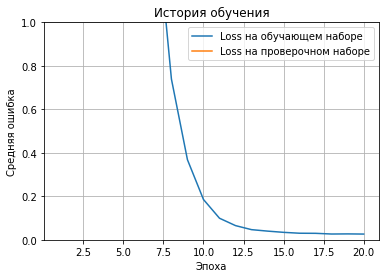

In [ ]:
history = model_d.fit(seq_train, epochs=20, validation_data=seq_test)
lh.append(history)
lh.plot(ylim=1)

### Модель на базе трансформера

In [ ]:
num_heads = 2 # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer
enc_maxlen = 14

enc_input = layers.Input(shape=(enc_maxlen,))
emb = TokenAndPositionEmbedding(enc_maxlen, voc_size, embed_dim)(enc_input)
x = Flatten()(emb)
x = Dense(128, activation='relu')(x)
output = layers.Dense(lex_size, activation='softmax')(x) 

model_t = keras.Model(enc_input, output, name="Transformer")


In [ ]:
lh = LearnHistory()
model_t.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
240/240 [==============================] - 3s 12ms/step - loss: 9.6224 - accuracy: 0.0000e+00 - val_loss: 9.6893 - val_accuracy: 0.0000e+00
Epoch 2/20
240/240 [==============================] - 3s 12ms/step - loss: 9.5590 - accuracy: 8.3333e-05 - val_loss: 9.8717 - val_accuracy: 0.0000e+00
Epoch 3/20
240/240 [==============================] - 3s 12ms/step - loss: 9.5320 - accuracy: 1.6667e-04 - val_loss: 10.0448 - val_accuracy: 0.0000e+00
Epoch 4/20
240/240 [==============================] - 3s 12ms/step - loss: 9.3458 - accuracy: 1.6667e-04 - val_loss: 10.4435 - val_accuracy: 0.0000e+00
Epoch 5/20
240/240 [==============================] - 3s 12ms/step - loss: 8.6297 - accuracy: 0.0045 - val_loss: 11.4473 - val_accuracy: 0.0000e+00
Epoch 6/20
240/240 [==============================] - 3s 12ms/step - loss: 7.4009 - accuracy: 0.0353 - val_loss: 13.4819 - val_accuracy: 0.0000e+00
Epoch 7/20
240/240 [==============================] - 3s 12ms/step - loss: 5.4770 - accuracy: 0.15

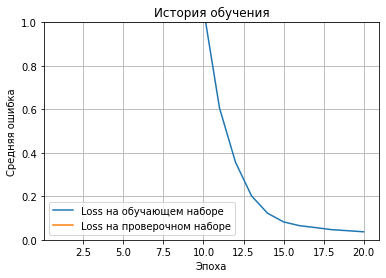

In [ ]:
history = model_t.fit(seq_train, epochs=20, validation_data=seq_test)
lh.append(history)
lh.plot(ylim=1)

Замечание по обучению. В обоих случаях модели быстро обучаются (запоминают) тренировочные данные, но демонстрируют полную неспособность находить запросы, близкие к тестовым. 

### Тестирование чат-бота

In [ ]:
myQuestions = (
    'ты очень умен!',
    'какой фильм посоветуешь?',
    'ты понимаешь меня?',
    'как дела?',
    'кто твой создатель?',
    'Как зовут трампа?',
    'Какая завтра погода?'
)

def testModel(model, questions):
    for question in questions:
        question = replaceSigns(question).lower()
        seq = strToTokens(question)
        pred = model.predict(seq)
        i = np.argmax(pred)
        answers = db[lexicon[i]]
        ans = random.choice(answers)
        print(f"Question: {question}")
        print("Answer: %s" % ans) 


Простая полносвязная модель

In [ ]:
testModel(model_d, myQuestions)

Question: ты очень умен ! 
Answer: обалдеть ! 
Question: какой фильм посоветуешь ? 
Answer: поговорить о фильмах всегда интересно. ты комедии любишь ? 
Question: ты понимаешь меня ? 
Answer: давай сменим тему.
Question: как дела ? 
Answer: у ботов не бывает плохого настроения.
Question: кто твой создатель ? 
Answer: тот ,  кто ждет от тебя подвигов.
Question: как зовут трампа ? 
Answer: .построю лабиринт ,  в котором смогу затеряться с тем ,  кто захочет меня найти...
Question: какая завтра погода ? 
Answer: сейчас-немедленно в эту минуту или в этом тысячелетии ? 


Та же, но с блоком энкодера трансформера

In [ ]:
testModel(model_t, myQuestions)

Question: ты очень умен ! 
Answer: я знаю что это значит. но не скажу.
Question: какой фильм посоветуешь ? 
Answer: гари потер
Question: ты понимаешь меня ? 
Answer: голубые ,  как яйца дрозда.
Question: как дела ? 
Answer: я еще не умею говорить об этом.
Question: кто твой создатель ? 
Answer: а ты разве не знаешь ? 
Question: как зовут трампа ? 
Answer: это-то так ,  но если глобально...
Question: какая завтра погода ? 
Answer: давай сыграем в игру: я притворюсь ,  будто знаю ответ на твой вопрос ,  а ты притворишься ,  будто тебя этот ответ устраивает.


### ВЫВОДЫ

Создание чат-бота - это не задача seq2seq, где подразумевается, что выходная последовательность должна как-то достаточно однозначно вытекать из входной (например как при переводе с одного языка на другой)

Создание чат-бота - скорее задача классификации. Особенность в том, что классов очень много (тысячи). Надо найти в базе запрос, максимально похожий (а лучше совпадающий) с введенным запросом и рандомно выдать один из заготовленных ответов.

## Перевод с русского на английский

Попытался сделать на базе своего трансформера перевод с русского на английский ограниченного набора предложений, построенных по схеме: подлежащее - сказуемое - прилагательное - дополнение,
например:

"Я вижу белый потолок"

Кроме того, слова ограничены словарем ниже.

In [ ]:
# Это наш словарь. 
pronouns = {
    'я': 'I',
    'мы': 'we',
    'вы': 'you',
    'ты': 'you',
    'он': 'he',
    'она': 'she',
    'они': 'they',
}
pronouns_verbs = {
    'я': {'видеть': 'вижу', 'слышать': 'слышу', 'рисовать': 'рисую', 'делать': 'делаю'},
    'мы': {'видеть': 'видим', 'слышать': 'слышим', 'рисовать': 'рисуем', 'делать': 'делаем'},
    'вы': {'видеть': 'видите', 'слышать': 'слышите', 'рисовать': 'рисуете', 'делать': 'делаете'},
    'ты': {'видеть': 'видишь', 'слышать': 'слышишь', 'рисовать': 'рисуешь', 'делать': 'делаешь'},
    'он': {'видеть': 'видит', 'слышать': 'слышит', 'рисовать': 'рисует', 'делать': 'делает'},
    'она': {'видеть': 'видит', 'слышать': 'слышит', 'рисовать': 'рисует', 'делать': 'делает'},
    'они': {'видеть': 'видят', 'слышать': 'слышат', 'рисовать': 'рисуют', 'делать': 'делают'},
}
verbs = {
    'видеть': 'see',
    'слышать': 'hear',
    'рисовать': 'paint',
    'делать': 'make',
}
adjectives = {
    'белый': 'white',
    'зеленый': 'green',
    'красивый': 'nice',
    'красный': 'red',
    'легкий': 'light',
    'синий': 'blue',
    'оранжевый': 'orange',
    'розовый': 'pink',
    'желтый': 'yellow',
    'гигантский': 'giant',
    'маленький': 'small',
}
nouns = {
    'дом': 'house',
    'потолок': 'ceil',
    'закат': 'sunset',
    'автомобиль': 'car',
    'корабль': 'ship',
    'холм': 'hill',
    'рисунок': 'drawing',
    'набросок': 'draft',
    'компьютер': 'computer',
    'пол': 'flour',
    'стул': 'chair',
    'стол': 'table',
}

In [ ]:
# Сделаем все возможные фразы из нашего словаря
ru_sentences, en_sentences = [], []
for p in pronouns.keys():
    for v in verbs.keys():
        for a in adjectives.keys():
            for n in nouns.keys():
                ru_sentence = p + ' ' + pronouns_verbs[p][v] + ' ' + a + ' ' + n
                ru_sentences.append(ru_sentence)
                suf = 's' if p in ('он', 'она') else ''
                en_sentence = pronouns[p] + ' ' + verbs[v] + suf + ' a ' + adjectives[a] + ' ' + nouns[n]
                en_sentences.append(en_sentence)


In [ ]:
# Случайные примеры
for i in np.random.choice(3696, 15):
    print(ru_sentences[i], ' => ', en_sentences[i])

я вижу синий рисунок  =>  I see a blue drawing
я вижу красный компьютер  =>  I see a red computer
он делает красный пол  =>  he makes a red flour
он делает синий автомобиль  =>  he makes a blue car
ты рисуешь белый корабль  =>  you paint a white ship
я вижу легкий потолок  =>  I see a light ceil
мы рисуем легкий потолок  =>  we paint a light ceil
я делаю белый стол  =>  I make a white table
вы рисуете синий компьютер  =>  you paint a blue computer
я рисую белый стол  =>  I paint a white table
он рисует синий автомобиль  =>  he paints a blue car
она видит желтый автомобиль  =>  she sees a yellow car
она делает легкий автомобиль  =>  she makes a light car
он делает оранжевый автомобиль  =>  he makes a orange car
мы рисуем маленький рисунок  =>  we paint a small drawing


In [ ]:
# Предложений всего:
len(en_sentences)

3696

In [ ]:
# Обернем английские фразы в тэги <start> & <end>
tagged_en_sentences = []
for sentence in en_sentences:
    tagged_en_sentences.append('<start> ' + sentence + ' <end>')

In [ ]:
# Отдельно токенизируем русские и английские слова
ru_tok = Tokenizer(oov_token='unknown')
ru_tok.fit_on_texts(ru_sentences)
print(ru_tok.word_index)

en_tok = Tokenizer(filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n', oov_token='unknown') # убрали < & >
en_tok.fit_on_texts(tagged_en_sentences)
print(en_tok.word_index)

{'unknown': 1, 'я': 2, 'мы': 3, 'вы': 4, 'ты': 5, 'он': 6, 'она': 7, 'они': 8, 'белый': 9, 'зеленый': 10, 'красивый': 11, 'красный': 12, 'легкий': 13, 'синий': 14, 'оранжевый': 15, 'розовый': 16, 'желтый': 17, 'гигантский': 18, 'маленький': 19, 'дом': 20, 'потолок': 21, 'закат': 22, 'автомобиль': 23, 'корабль': 24, 'холм': 25, 'рисунок': 26, 'набросок': 27, 'компьютер': 28, 'пол': 29, 'стул': 30, 'стол': 31, 'видит': 32, 'слышит': 33, 'рисует': 34, 'делает': 35, 'вижу': 36, 'слышу': 37, 'рисую': 38, 'делаю': 39, 'видим': 40, 'слышим': 41, 'рисуем': 42, 'делаем': 43, 'видите': 44, 'слышите': 45, 'рисуете': 46, 'делаете': 47, 'видишь': 48, 'слышишь': 49, 'рисуешь': 50, 'делаешь': 51, 'видят': 52, 'слышат': 53, 'рисуют': 54, 'делают': 55}
{'unknown': 1, '<start>': 2, 'a': 3, '<end>': 4, 'you': 5, 'see': 6, 'hear': 7, 'paint': 8, 'make': 9, 'i': 10, 'we': 11, 'he': 12, 'she': 13, 'they': 14, 'white': 15, 'green': 16, 'nice': 17, 'red': 18, 'light': 19, 'blue': 20, 'orange': 21, 'pink': 22,

In [ ]:
maxlen = 8 # максимальная длина фразы
ru_seqs = []
for s in ru_sentences:
    words = s.lower().split()
    tokens = ru_tok.texts_to_sequences([words])
    seq = pad_sequences(tokens, maxlen=maxlen , padding='post')
    ru_seqs.append(seq.reshape((maxlen,)))
X = np.array(ru_seqs)    

en_seqs = []
for s in tagged_en_sentences:
    words = s.lower().split()
    tokens = en_tok.texts_to_sequences([words])
    seq = pad_sequences(tokens, maxlen=maxlen , padding='post')
    en_seqs.append(seq.reshape((maxlen,)))
Y = np.array(en_seqs)    

ru_voc_size = len(ru_tok.word_index) + 1
en_voc_size = len(en_tok.word_index) + 1
print(ru_voc_size, en_voc_size)

56 42


In [ ]:
# Сделаем массив английских фраз в формате OHE без тэга <start>
Z = np.zeros((Y.shape[0], maxlen, en_voc_size), dtype=np.int32)
for n in range(Y.shape[0]):
    for j in range(maxlen - 1):
        Z[n, j, Y[n, j + 1]] = 1 # OHE, убираем <start> из первой позиции.

In [ ]:
# Делим наши предложения на обучающую и тестовую выборки
N = 3000 # число образцов для обучения
inds = np.array([i for i in range(X.shape[0])])
np.random.shuffle(inds)
x_train = X[inds[:N]]
y_train = Y[inds[:N]]
z_train = Z[inds[:N]]
x_test = X[inds[N:]]
y_test = Y[inds[N:]]
z_test = Z[inds[N:]]  # to_categorical(y_test, en_voc_size)

In [ ]:
z_test.shape

(696, 8, 42)

In [ ]:
# Наша модель-трансформер
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
enc_maxlen = 8
dec_maxlen = 8

enc_input = Input(shape=(None,))
dec_input = Input(shape=(None,))

enc_emb = TokenAndPositionEmbedding(enc_maxlen, ru_voc_size, embed_dim)(enc_input)
dec_emb = TokenAndPositionEmbedding(dec_maxlen, en_voc_size, embed_dim)(dec_input)

x = TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(enc_emb)
x = TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(x)
enc_out = TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(x)

x = TransformerDecoderBlock(embed_dim, num_heads, ff_dim)([dec_emb, enc_out])
x = TransformerDecoderBlock(embed_dim, num_heads, ff_dim)([x, enc_out])
dec_out = TransformerDecoderBlock(embed_dim, num_heads, ff_dim)([x, enc_out])
output = layers.Dense(en_voc_size, activation='softmax')(dec_out) 

Encoder = keras.Model(enc_input, enc_out, name="Encoder")
Decoder = keras.Model([dec_input, enc_input], output, name="Decoder")

model = keras.Model([enc_input, dec_input], output, name="Transformer")
lh = LearnHistory()


In [ ]:
model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
token_and_position_embedding_2  (None, None, 64)     4096        input_3[0][0]                    
__________________________________________________________________________________________________
transformer_encoder_block_3 (Tr (None, None, 64)     33472       token_and_position_embedding_2[0]
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
________________________________________________________________________________________

Epoch 1/10
150/150 [==============================] - 4s 28ms/step - loss: 1.9717 - accuracy: 0.4207 - val_loss: 0.9008 - val_accuracy: 0.6638
Epoch 2/10
150/150 [==============================] - 3s 17ms/step - loss: 0.7678 - accuracy: 0.7270 - val_loss: 0.3032 - val_accuracy: 0.8703
Epoch 3/10
150/150 [==============================] - 3s 17ms/step - loss: 0.3017 - accuracy: 0.8612 - val_loss: 0.0680 - val_accuracy: 0.8750
Epoch 4/10
150/150 [==============================] - 3s 17ms/step - loss: 0.0972 - accuracy: 0.8748 - val_loss: 0.0196 - val_accuracy: 0.8750
Epoch 5/10
150/150 [==============================] - 3s 17ms/step - loss: 0.0349 - accuracy: 0.8751 - val_loss: 0.0072 - val_accuracy: 0.8750
Epoch 6/10
150/150 [==============================] - 3s 17ms/step - loss: 0.0139 - accuracy: 0.8750 - val_loss: 0.0030 - val_accuracy: 0.8750
Epoch 7/10
150/150 [==============================] - 3s 17ms/step - loss: 0.0059 - accuracy: 0.8750 - val_loss: 0.0013 - val_accuracy: 0.8750

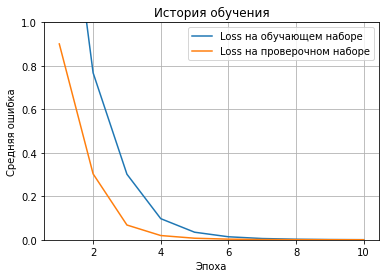

22/22 [==============================] - 0s 14ms/step - loss: 1.4168e-04 - accuracy: 0.8750
Loss on test: 0.0001


In [ ]:

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-09), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Запустим обучение 
history = model.fit([x_train, y_train], z_train, batch_size=20, validation_data=([x_test, y_test], z_test), epochs=10) 
lh.append(history)
lh.plot(ylim=1)
score = model.evaluate([x_test, y_test], z_test)
print("Loss on test: %.4f" % score[0])

### Тестируем перевод

In [ ]:
# Попробуем получить переводы первых n фраз тестовой выборки x_test[n]:

for n in range(20):
    dec_inp = np.zeros((1, 8), dtype=np.int32)
    dec_inp[0, 0] = 2 # 'start' token
    tr = '' # translation
    for i in range(8): # Получаем каждое следующее слово перевода и добавляем его на вход декодера
        pred = model.predict([x_test[n:n+1], dec_inp[:,:i+1]])
        # print('i=', i, pred.shape) # debug
        ind = np.argmax(pred[0, i]) # получаем токен английского слова
        if ind == 0 or ind == 4: # 4 = <end>
            break
        word = en_tok.index_word[ind] # получаем само слово
        tr += (word + ' ')
        # print(ind, word) # debug
        dec_inp[0, i+1] = ind # добавляем токен полученного слова во входящую последовательность
    for i in range(4):
        print(ru_tok.index_word[x_test[n, i]], end=' ') # выводим русскую фразу по словам
    print(' =>', tr) # и английский перевод



они видят маленький пол  => they make a small flour 
я слышу зеленый дом  => make make a green house 
она слышит красивый корабль  => she hears a nice ship 
они делают оранжевый стол  => they make a orange table 
она видит легкий закат  => make make a light sunset 
вы делаете красивый холм  => make make a nice hill 
он слышит зеленый набросок  => he hears a green draft 
мы слышим гигантский корабль  => we make a giant ship 
я слышу белый дом  => make make a white house 
она рисует красный автомобиль  => she hears a red car 
вы делаете маленький компьютер  => make make a small computer 
он делает красивый закат  => he sees a nice computer 
мы видим оранжевый компьютер  => make make a orange computer 
я вижу маленький компьютер  => make make a small computer 
они делают красный компьютер  => they make a red computer 
мы видим гигантский корабль  => we make a giant ship 
он рисует желтый стол  => he sees a yellow table 
она делает красный дом  => she make a red house 
они видят маленький 

Некоторые фразы переведены правильно, но много ошибок связано с заменой подлежащего и/или сказуемого на слово "make". Причем это ошибочное слово зависит от случайного разбиения на тестовую выборку - при другом разбиении будет другое слово вместо make.

Возможно я где-то допустил ошибку, но видно, что трансформер в целом работает.

## Русифицированный GPT-3

Появилась весть что [Сбер выложил русскоязычную модель GPT-3 Large с 760 миллионами параметров в открытый доступ](https://habr.com/ru/company/sberbank/blog/524522/)

Я попытался ее загрузить самую мелкую вот [отсюда:](https://huggingface.co/sberbank-ai/rugpt2large)


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 3.4MB/s 
     |████████████████████████████████| 2.9MB 18.7MB/s 
     |████████████████████████████████| 890kB 52.0MB/s 
     |████████████████████████████████| 1.1MB 46.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=15cb64cf6fdc2042cf08e64ff2b62b51d2a08641d3b31ac045cb58e74a070667
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt2large")

model = AutoModel.from_pretrained("sberbank-ai/rugpt2large")

Параметры модели:

```
{
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 1280,
  "n_head": 20,
  "n_layer": 36,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bfloat16": false,
  "vocab_size": 50257
}
```

Но практически поработать с моделью не удалось. Она на pyTorch, который я, к сожалению, пока не освоил. К тому же никаких описаний и примеров использования я не нашел.

# ИТОГИ

Тема NLP очень интересна, обширна и сложна. Я попытался охватить максимальное число задач, разобраться в работе трансформера. К сожалению, не все задуманное получилось - просто не хватило времени. Недели слишком мало чтобы разобраться во всех тонкостях, но я вынужден переключиться на курсовую работу.